In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from transformers import DataCollatorWithPadding

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from datasets import load_from_disk

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score

2025-09-14 11:07:15.644314: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In this notebook we are going to integrate three different models that we trained on three different 'kind' of data that capture different aspects of each item. More precisely we have trained three different models:
- `RoBERTa`: for analyzing text (the description of the item).
- Two `MLP`, one for analyzing the the properties and one for analyzing statistical information and categorical features.

The idea here is to integrate all these three models, putting on top of them a `MLP` that performes the classification task.
The final model is the following:

<img src="../images/final_model.png" alt="Final model" width="600">

In the following we present the architecture for the two `MLP`. Actually, here we are intersted only in extracting the features learned by the two models, so we modified a bit the architecture to extract such fetaures from the last layer.

In [2]:
class PropertiesClassifier(nn.Module):
    '''
    input_dim = 29 (the number of properties that we used)
    hidden1 = 20
    hidden2 = 10
    out_dim = 3 (the number of classes)
    '''
    def __init__(self, input_dim, hidden1, hidden2, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, out_dim)

        self.act_fn = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.fc2(x)
        embedding = self.act_fn(x)
        x = self.fc3(embedding)
        x = self.softmax(x)

        return x, embedding     # ← we are intersted in the embeddings

In [3]:
class StatsClassifier(nn.Module):
    '''
    input_dim = 144 (number of attributes resulting after the one-hot encoding)
    hidden1 = 70
    hidden2 = 10
    out_dim = 3 (the number of classes)
    '''
    def __init__(self, input_dim, hidden1, hidden2, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, out_dim)

        self.act_fn = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.fc2(x)
        embedding = self.act_fn(x)
        x = self.fc3(embedding)
        x = self.softmax(x)

        return x, embedding

Now we proceed with loading the trained models.

In [5]:
# RoBERTa
roberta = AutoModelForSequenceClassification.from_pretrained("../models/RoBERTa")
tokenizer = AutoTokenizer.from_pretrained("../models/RoBERTa")

# Properties classifier
prop_state_dict = torch.load("../models/prop_classifier.tar", weights_only=True)
prop_classifier = PropertiesClassifier(input_dim=29, hidden1=20, hidden2=10, out_dim=3)
prop_classifier.load_state_dict(prop_state_dict)

# Statistical classifier
stats_state_dict = torch.load("../models/stats_classifier.tar", weights_only=True)
stats_classifier = StatsClassifier(input_dim=144, hidden1=70, hidden2=10, out_dim=3)
stats_classifier.load_state_dict(stats_state_dict)

<All keys matched successfully>

In the following we define a functions for extracting the embeddings.

In [6]:
# Function for extracting text emebdding from RoBERTa
def get_embeddings_from_roberta(text, model, tokenizer, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors="pt", max_length=max_length,
                         padding='max_length', truncation=True)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # extract the hidden states
        hidden_states = outputs.hidden_states

        # Here we consider only the last layer
        embeddings = hidden_states[-1]  # (batch_size, sequence_length, hidden_size)
        embeddings = embeddings.squeeze(dim=0) # shape: (sequence_length, hidden_size)

        # Since some of the tokens can be padding tokens, we don't want
        # to consider them, so we perform an element-wise multiplication
        # to set them to zero.
        attention_mask = attention_mask.float()
        attention_mask = torch.transpose(attention_mask, 0, 1)

        sentence_embedding = embeddings * attention_mask

        # Note, we don't use torch.mean but instead we sum over the rows and then
        # divide by the numer of non-padding tokens (attention_mask.sum() gives us
        # exactly this infomration). This way we take somehow into account the
        # length of the sequence
        sentence_embedding = torch.sum(sentence_embedding, dim=0) / attention_mask.sum()

    return sentence_embedding


In [7]:
# Function for extracting the embeddings from the MLP
def get_embeddings_from_MLP(model, input):
  model.eval()
  _, embedding = model.forward(input)

  return embedding

### Final Model
Now, we build the `MLP` to put on top of the three models that we trained before and perform the final classification.

In [8]:
class FinalMLP(nn.Module):
    '''
    1. sentence embedding, size: 768
    2. properties features, size: 10
    3. statistical features, size: 10

    input_dim = 788
    hidden = 500
    out_dim = 3
    '''
    def __init__(self, input_dim, hidden1, hidden2, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, out_dim)

        self.act_fn = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.fc2(x)
        x = self.act_fn(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [9]:
# We initialize the model
final_model = FinalMLP(input_dim=788, hidden1=500, hidden2=250, out_dim=3)

### Data Preparation
Now we are going to prepare the dataset to train the final model. What we are going to do is to extract the embeddings for the different kinds of data (text, properties, statistics and categorical) and then concatenate them.

In [10]:
mapping = {'cultural agnostic': 0.0, 'cultural representative': 1.0, 'cultural exclusive': 2.0}

In [11]:
class IntegratedDataset(data.Dataset):

    def get_sentence_embedding(self, text):
        # extract the sentence embedding from roberta
        sentence_embedding = get_embeddings_from_roberta(text, roberta, tokenizer)

        return sentence_embedding

    def get_prop_features(self, row):
        '''
        Here we prepare the data for the properties. We going to use a kind
        of one-hot encoding; for each item, we create a vector that has 1.0,
        if in the corresponing position the property is not None, 0.0 otherwise.
        E.g.:
        item = [Italy, None, None, Sicily, None, ...]
        vector = [1.0, 0.0, 0.0, 1.0, 0.0, ...]
        '''

        vector = []
        for value in row:
            vector.append(1.0 if not pd.isna(value) else 0.0)

        return vector

    def __init__(self, desc_dataset, prop_dataset, stats_dataset, labels):
        '''
        desc_dataset: dataset containing item's descriptions
        prop_dataset: dataset containing the values of item's properties
        stats_dataset: dataset containing the statistical information
        '''

        self.num_samples = len(desc_dataset)

        self.data = []
        for i in range(self.num_samples):

            # we set torch.no_grad() because here we don't wan't to keep track of the gradients
            with torch.no_grad():

                text_embedding = self.get_sentence_embedding(desc_dataset['description'][i]).detach()

                prop_tensor = torch.tensor(self.get_prop_features(prop_dataset.iloc[i]), dtype=torch.float32)
                prop_features = get_embeddings_from_MLP(prop_classifier, prop_tensor).detach()

                stats_tensor = torch.tensor(stats_dataset[i], dtype=torch.float32)
                stats_features = get_embeddings_from_MLP(stats_classifier, stats_tensor).detach()

                # we concatenate the different embeddings
                integrated_input = torch.cat((text_embedding, prop_features, stats_features), 0)

                if labels is not None:
                  label = torch.tensor(mapping[labels.iloc[i]])

                # the final dataset will be a list of dictionaries with two keys:
                # inputs: concatenated embeddings
                # outputs: label
                # or simply inputs for the test set
                if labels is not None:
                  sample = {'inputs': integrated_input, 'outputs': label}
                else:
                  sample = {'inputs': integrated_input}

                self.data.append(sample)


    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.data[index]



Since there are some mismatches between the various datasets (properties, statistcs and decription), we do some cleaning.  
NOTE: the mismatch is due to the fact that we had to remove some rows from the statistical datasets.

In [13]:
train_props = pd.read_csv('../datasets/properties/training_props.csv')
val_props = pd.read_csv('../datasets/properties/validation_props.csv')

In [28]:
# Load the stats datasets
train_stats = pd.read_csv('../datasets/statistics/train_stats.csv')
val_stats = pd.read_csv('../datasets/statistics/val_stats.csv')

# In the item column we still have the full links (http://www.wikidata.org/entity/Q32786)
# therefore we modify it to keep only the item's identifier (Q32786)
train_stats['item'] = train_stats['item'].apply(lambda x: x.strip().split('/')[-1])
val_stats['item'] = val_stats['item'].apply(lambda x: x.strip().split('/')[-1])

# Finally we remove from the properties datasets the items that are not present in the
# statistical datasets
cleaned_train_props = train_props[train_props['item'].isin(train_stats['item'])]
cleaned_val_props = val_props[val_props['item'].isin(val_stats['item'])]

# We reset the index
cleaned_train_props = cleaned_train_props.reset_index(drop=True)
cleaned_val_props = cleaned_val_props.reset_index(drop=True)

# Finally, we drop the first two columns (index, item) since we don't need them
cleaned_train_props = cleaned_train_props.drop(columns=['Unnamed: 0','item'])
cleaned_val_props = cleaned_val_props.drop(columns=['Unnamed: 0','item'])

Now we need to do the same for the descriptions.

In [30]:
datasets = load_from_disk('../datasets/train_and_val')
train_descirptions = pd.DataFrame({'item': list(datasets['train']['item']), 'description': list(datasets['train']['description'])})
val_descriptions = pd.DataFrame({'item': list(datasets['validation']['item']), 'description': list(datasets['validation']['description'])})

# As before, we keep only the item's idetifier
train_descirptions['item'] = train_descirptions['item'].apply(lambda x: x.strip().split('/')[-1])
val_descriptions['item'] = val_descriptions['item'].apply(lambda x: x.strip().split('/')[-1])

In [32]:
cleaned_train_descriptions = train_descirptions[train_descirptions['item'].isin(train_stats['item'])]
cleaned_val_descriptions = val_descriptions[val_descriptions['item'].isin(val_stats['item'])]

cleaned_train_descriptions = cleaned_train_descriptions.reset_index(drop=True)
cleaned_val_descriptions = cleaned_val_descriptions.reset_index(drop=True)

In the stats datasets we retrieved some useful statistical data, that we thought could help to perform the classification task. Precisey we stored the following informations:

We have columns that store information about the text distribution, and more precisely we have the following attributes:
- text_distribution: array storing length if wikipedia texts connected to the item
- avg_text: mean of the text distribution quantity
- std_text: standard deviation of the distrinution quantity
- len: number of wikipedia links connected to the item
- entropy_text: entropy computed on the text_distrinution
- gini_text: gini's index computed on text_distribution
- sum_over_texts: sum of the values in text distribution


Then we have another set of columns storing data about the references to each item's wikipedia page. So similarly to before we have:
- ref_distribution: array storing the number of references to each item wikipedia page
- avg_ref: mean of the ref_distribution quantity
- std_ref: standard deviation of the ref_distribution quantity
- entropy_ref: entropy computed on the ref_distrbution
- gini_ref: gini's index computed on the ref_distribution
- sum_over_ref: sum of the values in the ref_didtribution quantity

Finally, we have otther four columns:
- h_adj_descr: euristic counting the number of attributes (italian, chinese, english,...) on the description
- h_nat_descr: euristic counting the number of nations in the description of the item
- h_adj_engtext: euristic counting the number of attributes (italian, chinese, english,...) on the english wikipedia text
- h_nat_engtext: euristic counting the number of nations in the english wikipedia text.

Here we are going to keep also some categorical features that are useful in performing the classification task. To deal with this we are going to perform a **one-hot** encoding on these attributes. Moreover, it is useful to normalize the statistical features, since they have different scales. To do so we are going to use the `StandardScaler` module from `sklearn`, that applies the following transformation to the data:
$$\tilde{x} = \frac{x - \mu}{\sigma}$$
where $\mu$ is the mean of the trainig samples and $\sigma$ the standard deviation. With this transformation the whole dataset will have, approximately. mean 0 and standard deviation 1.

Since we have two different tranformations to apply to the dataset we are going to use the `ColumnTranformer` module from sklearn, that simplifies considerably the whole procedure.

In [33]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_features = ['type', 'category', 'subcategory']
stats_features = ['std_text', 'avg_text', 'len', 'entropy_text', 'gini_text',
       'sum_over_texts', 'std_ref', 'avg_ref', 'sum_over_ref', 'entropy_ref',
       'gini_ref', 'h_adj_descr', 'h_nat_descr', 'h_adj_engtext',
       'h_nat_engtext']

In [34]:
# Here we are going to drop the text_distribution and ref_distribution columns.
# We do so because they have a different type of data structure (array) with respect
# to the other attributes (scalars) and so it is a bit more complicated to deal with
# both kind of data. Moreover, there are other attributes that store all the relevant information
# about these two distributions. Then we also drop the 'item', 'name' and 'label' column

train_labels = train_stats['label']
train_stats = train_stats.drop(columns=['item', 'name', 'label',
                                          'countryLabel', 'subclass_ofLabel', 'text_distribution',
                                          'ref_distribution'])
val_labels = val_stats['label']
val_stats = val_stats.drop(columns=['item', 'name', 'label',
                                          'countryLabel', 'subclass_ofLabel', 'text_distribution',
                                          'ref_distribution'])

In [35]:
ct = ColumnTransformer(
    [("text_preprocess", encoder, categorical_features),
     ('stats_preprocess', StandardScaler(), stats_features)]
)

## tranformerd datasets
transformed_train_stats = ct.fit_transform(train_stats)
transformed_val_stats = ct.transform(val_stats)

Before proceeding, let's male a fast recap of the datasets that we have:

- Two datasets containing the values of the properties:
    - cleaned_train_props
    - cleaned_val_props
- Two datasets containing the descriptions:
    - cleaned_train_descriptions
    - cleaned_val_descriptions
- Two datasets containing statistical information:
    - transformed_train_stats
    - tranformed_val_stats

In [38]:
# Sanity check
assert len(cleaned_train_descriptions) == len(cleaned_train_props) == len(transformed_train_stats) == len(train_labels)
assert len(cleaned_val_descriptions) == len(cleaned_val_props) == len(transformed_val_stats) == len(val_labels)

In [39]:
# Now we can generate the training and validation datasets

training_samples = IntegratedDataset(desc_dataset=cleaned_train_descriptions,
                                     prop_dataset=cleaned_train_props,
                                     stats_dataset=transformed_train_stats,
                                     labels=train_labels)

validation_samples = IntegratedDataset(desc_dataset=cleaned_val_descriptions,
                                      prop_dataset=cleaned_val_props,
                                      stats_dataset=transformed_val_stats,
                                      labels=val_labels)

### The Trainer class

In [41]:
class Trainer():

    def __init__(self, model, loss_function, optimizer, num_epochs):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.num_epochs = num_epochs

    def compute_f1_score(self, predictions, labels):
        discrete_predictions = [preds.detach().clone().argmax(dim=1) for preds in predictions]
        discrete_predictions = np.array(discrete_predictions)
        labels_array = np.array(labels)

        f1 = f1_score(labels_array.flatten(), discrete_predictions.flatten(), average='macro')
        return f1


    def compute_accuracy(self, predictions, labels):
        discrete_predictions = predictions.detach().clone()
        discrete_predictions = discrete_predictions.argmax(dim=1)

        return torch.mean(torch.Tensor([1 if p==l else 0 for p, l in list(zip(discrete_predictions.view(-1), labels.view(-1)))])).item()

    def train(self, train_dataset, valid_dataset):
        train_loss = []
        train_accuracy = []
        train_f1_score = []
        valid_loss = []
        valid_accuracy = []
        valid_f1_score = []

        for epoch in tqdm(range(self.num_epochs)):
            epoch_loss = 0.0
            epoch_accuracy = 0.0
            epoch_f1_score = 0.0

            epoch_predictions = []
            epoch_labels = []

            for step, sample in enumerate(train_dataset):
                inputs = sample['inputs']
                labels = sample['outputs']

                # set the gradients to zero
                self.optimizer.zero_grad()

                # compute the predictions
                predictions = self.model(inputs)
                epoch_predictions.append(predictions)

                labels = labels.view(-1).long()
                epoch_labels.append(labels)

                #compute the loss
                sample_loss = self.loss_function(predictions, labels)

                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.tolist()
                epoch_accuracy += self.compute_accuracy(predictions, labels)



            avg_epoch_loss = epoch_loss / len(train_dataset)
            avg_epoch_accuracy = epoch_accuracy / len(train_dataset)
            epoch_f1_score = self.compute_f1_score(epoch_predictions, epoch_labels)


            if epoch % 5 == 0:
                print(f'Avg training loss at epoch {epoch}: {avg_epoch_loss}')
                print(f'Avg training accuracy at epoch {epoch}: {avg_epoch_accuracy}')
                print(f'Training f1_score at epoch {epoch}: {epoch_f1_score}\n')

            valid_loss_epoch, valid_accuracy_epoch, valid_f1_score_epoch = self.evaluate(valid_dataset)

            if epoch % 5 == 0:
                print(f'Validation loss at epoch {epoch}: {valid_loss_epoch}')
                print(f'Validation accuracy at epoch {epoch}: {valid_accuracy_epoch}')
                print(f'Validation f1_score at epoch {epoch}: {valid_f1_score_epoch}\n\n')

            ## training scores
            train_loss.append(avg_epoch_loss)
            train_accuracy.append(avg_epoch_accuracy)
            train_f1_score.append(epoch_f1_score)

            ## validation scores
            valid_loss.append(valid_loss_epoch)
            valid_accuracy.append(valid_accuracy_epoch)
            valid_f1_score.append(valid_f1_score_epoch)


        return {
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "train_f1_score": train_f1_score,
            "valid_loss": valid_loss,
            "valid_accuracy": valid_accuracy,
            "valid_f1_score": valid_f1_score
            }


    def evaluate(self, validation_dataset):
        valid_loss = 0.0
        validation_accuracy = 0.0
        valid_f1_score = 0.0

        predictions_list = []
        labels_list = []

        with torch.no_grad():
            for sample in validation_dataset:
                inputs = sample['inputs']
                labels = sample['outputs']

                predictions = self.model(inputs)
                predictions_list.append(predictions)

                labels = labels.view(-1).long()
                labels_list.append(labels)

                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.tolist()

                validation_accuracy += self.compute_accuracy(predictions, labels)


        avg_valid_loss = valid_loss / len(validation_dataset)
        avg_valid_accuracy = validation_accuracy / len(validation_dataset)
        valid_f1_score = self.compute_f1_score(predictions_list, labels_list)

        return avg_valid_loss, avg_valid_accuracy, valid_f1_score

In [42]:
# Use the DataLoader class to load the datasets and create two interable objects
training_dataset = DataLoader(training_samples, batch_size=16, shuffle=True, drop_last=True)
validation_dataset = DataLoader(validation_samples, batch_size=8, drop_last=True)

In [43]:
trainer = Trainer(final_model,
                  loss_function = nn.CrossEntropyLoss(),
                  optimizer=optim.SGD(final_model.parameters(), lr=0.01),
                  num_epochs=50)

In [44]:
history = trainer.train(training_dataset, validation_dataset)

  0%|          | 0/50 [00:00<?, ?it/s]

Avg training loss at epoch 0: 0.8735972191628252
Avg training accuracy at epoch 0: 0.7025193798449613
Training f1_score at epoch 0: 0.6287130395474739

Validation loss at epoch 0: 0.8427355772740132
Validation accuracy at epoch 0: 0.6993243243243243
Validation f1_score at epoch 0: 0.6731989142783078


Avg training loss at epoch 5: 0.7317205775307747
Avg training accuracy at epoch 5: 0.8155684754521964
Training f1_score at epoch 5: 0.8061884029607148

Validation loss at epoch 5: 0.8247219485205572
Validation accuracy at epoch 5: 0.6993243243243243
Validation f1_score at epoch 5: 0.6782212885154061


Avg training loss at epoch 10: 0.7236489555016352
Avg training accuracy at epoch 10: 0.8238049095607235
Training f1_score at epoch 10: 0.8147195080059744

Validation loss at epoch 10: 0.811382947741328
Validation accuracy at epoch 10: 0.722972972972973
Validation f1_score at epoch 10: 0.7037707926681217


Avg training loss at epoch 15: 0.7176825815393019
Avg training accuracy at epoch 15: 0.

### Plots

#### Loss

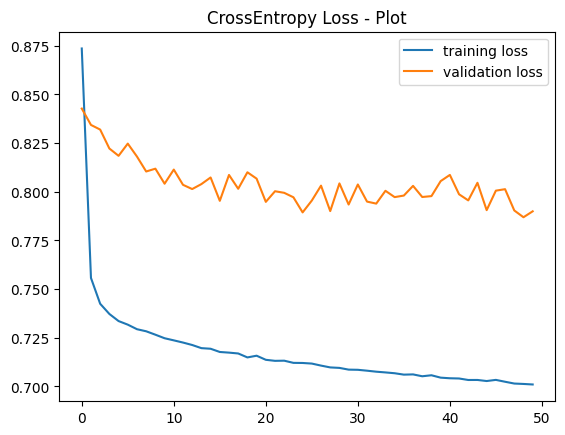

In [45]:
plt.title('CrossEntropy Loss - Plot')
plt.plot(history["train_loss"], label="training loss")
plt.plot(history["valid_loss"], label="validation loss")
plt.legend()

plt.show()

#### Accuracy

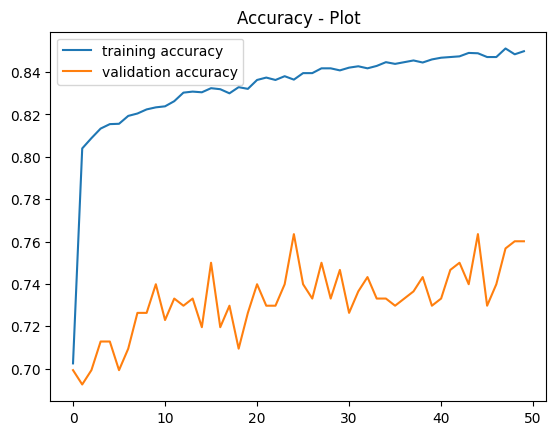

In [46]:
plt.title("Accuracy - Plot")
plt.plot(history["train_accuracy"], label="training accuracy")
plt.plot(history["valid_accuracy"], label="validation accuracy")
plt.legend()

plt.show()

#### F1-score

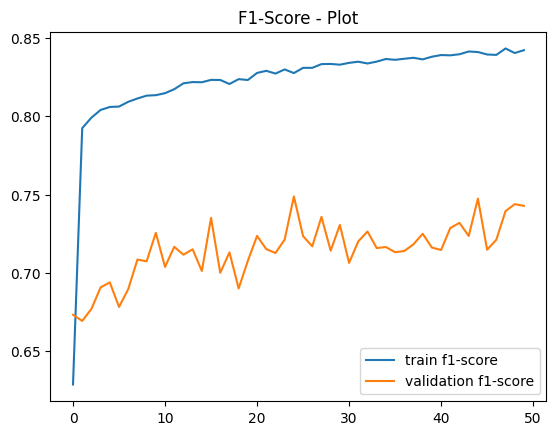

In [47]:
plt.title("F1-Score - Plot")
plt.plot(history["train_f1_score"], label="train f1-score")
plt.plot(history["valid_f1_score"], label="validation f1-score")
plt.legend()

plt.show()

### Let's save the final model

In [48]:
state_dict = final_model.state_dict()
torch.save(state_dict, "../models/final_model.tar")